### Домашнее задание к занятию "Классификация: Логистическая регрессия и SVM"

In [65]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
data = pd.read_csv('data/adult_csv.csv', delimiter = ',')

In [55]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


In [56]:
data.shape # размерность датасета

(48842, 15)

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capitalgain     48842 non-null  int64 
 11  capitalloss     48842 non-null  int64 
 12  hoursperweek    48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  class           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [58]:
data.describe()

,age,fnlwgt,education-num,capitalgain,capitalloss,hoursperweek
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,1.771078,1.896641e+05,10.078089,0.200319,0.114942,1.950698
std,1.295378,1.056040e+05,2.570973,0.746182,0.556924,0.897038
min,0.000000,1.228500e+04,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.175505e+05,9.000000,0.000000,0.000000,2.000000
50%,2.000000,1.781445e+05,10.000000,0.000000,0.000000,2.000000
75%,3.000000,2.376420e+05,12.000000,0.000000,0.000000,2.000000
max,4.000000,1.490400e+06,16.000000,4.000000,4.000000,4.000000


#### 1. Удаляем пропущенные значения

In [60]:
data = data[pd.isnull(data['workclass']) == 0]
data = data[pd.isnull(data['occupation']) == 0]
data = data[pd.isnull(data['native-country']) == 0]

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education-num   45222 non-null  int64 
 5   marital-status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capitalgain     45222 non-null  int64 
 11  capitalloss     45222 non-null  int64 
 12  hoursperweek    45222 non-null  int64 
 13  native-country  45222 non-null  object
 14  class           45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [62]:
data['class'].value_counts() # посмотрим, насколько сбалансированы классы. Результат: соотношение примерно 3:1.

<=50K    34014
>50K     11208
Name: class, dtype: int64

Построим как отличается распределение параметра "fnlwgt" для значений целевой переменной. Результат: Распределение одинаковое. 
Можно сделать вывод, что признак "fnlwgt" можно не испольдзовать для моделирования.

<function matplotlib.pyplot.show(close=None, block=None)>

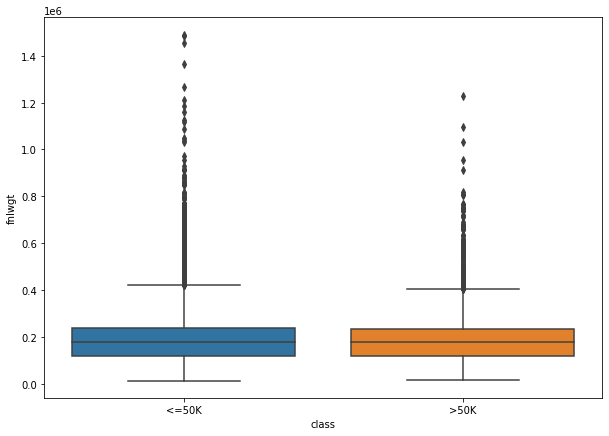

In [79]:
plt.figure(figsize=(10,7))
sns.boxplot(y = data["fnlwgt"], x = data["class"])
plt.show


#### 2. Преобразуем целевую категориальную переменную 'class' в число при помощи LabelEncoder

In [80]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [81]:
le.fit( data['class'])

LabelEncoder()

In [82]:
y = pd.Series(data = le.transform(data['class']))
y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int32

In [83]:
le.classes_

array(['<=50K', '>50K'], dtype=object)

#### 3. Отберем столбцы на которых будем строить модель.  
Признак 'education' исключим, так как есть числовая переменная 'education-num', которая содержит уровень образования.

In [84]:
exept_col = ['fnlwgt','education','class']
select_col = [x for x in data.columns if x not in exept_col]
select_data = data.loc[:, select_col]
select_data.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


#### 4. Посмотрим диапазон значений у категориальных переменных. Все категориальные переменные переведем в значения 0 и 1, добавив столбцы с соответствующими названиями

In [85]:
select_data['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', 'Without-pay'], dtype=object)

In [86]:
select_data['marital-status'].unique()

array(['Never-married', 'Married-civ-spouse', 'Divorced',
       'Married-spouse-absent', 'Separated', 'Married-AF-spouse',
       'Widowed'], dtype=object)

In [87]:
select_data['occupation'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Transport-moving',
       'Farming-fishing', 'Machine-op-inspct', 'Tech-support',
       'Craft-repair', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [88]:
select_data['race'].unique()

array(['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo',
       'Other'], dtype=object)

In [89]:
select_data['relationship'].unique()

array(['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [90]:
select_data['sex'].unique()

array(['Male', 'Female'], dtype=object)

In [91]:
select_data['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', 'Mexico',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Poland', 'Columbia', 'Cambodia', 'Thailand',
       'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'Italy', 'China', 'South', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

In [92]:
X = pd.get_dummies (select_data, columns = ['workclass', 'marital-status', 'occupation', 'race', 'relationship', 'sex', 'native-country'])
X.columns

Index(['age', 'education-num', 'capitalgain', 'capitalloss', 'hoursperweek',
       'workclass_Federal-gov', 'workclass_Local-gov', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay',
       'marital-status_Divorced', 'marital-status_Married-AF-spouse',
       'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'race_Amer-Indian-E

#### 5. Строим модель логистической регрессии

In [109]:
##from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression

model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
##model = LogisticRegression(max_iter=1000)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [116]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [117]:
prediction = model.predict(X_test)

In [118]:
model.score(X_train, y_train) # результат на обучающей выборке

0.8473615833264229

In [119]:
model.score(X_test, y_test) # результат на тестовой выборке

0.8488667772249862

#### 6.Строим модель методом SVM

In [99]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) 

In [100]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [101]:
clf.score(X_train, y_train) # результат на обучающей выборке

0.8526615068709524

In [102]:
clf.score(X_test, y_test) # результат на тестовой выборке

0.8492666027861723

#### В данном примере обе модели показали достаточно хорошие результаты и могут использованы для предсказания. У обоих моделей получены качество на тестовом датасете не ухудшается существенно, что говорит об отсутствии переобучения.